In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

import flickr_api
from flickr_api import Photo
from sklearn.cluster import DBSCAN

import torch

from dataset.load import LoadDataset
from dataset.utils import load_credentials
from utils.vis import make_tensor, visualize_grid

api_key, api_secret = load_credentials()
flickr_api.set_keys(api_key=api_key, api_secret=api_secret)

# Baseline: clustering using only location (lat/lon)

In [5]:
# Load dataset and count number of photos
path = "data/paris_1000_test.h5"
dataset = LoadDataset(path)
print(dataset.size(), "photos")

999 photos


In [4]:
# Get features from dataset
it = dataset.get()
X = []
for i, row in enumerate(it):
    metadata, _, embedding = row

    # Location
    lat = float(metadata["location"]["latitude"])
    lon = float(metadata["location"]["longitude"])
    
    # Tags    
    tags = " ".join([tag["text"] for tag in metadata["tags"]])

    # Embedding
    emb = embedding.tolist()

    id = int(metadata["id"])
    X.append([id, lat, lon])

X = np.asarray(X)
X.shape

(999, 3)

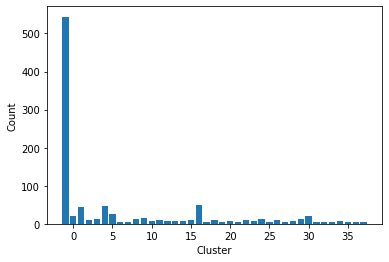

In [5]:
# Sampling on a smaller subset
X_train = X[:, 1:]

# Train clustering using DBSCAN
kms_per_radian = 6371.0088
meters = 30
epsilon = (meters * 0.001) / kms_per_radian
db = DBSCAN(eps=epsilon, algorithm='ball_tree', metric='haversine')
db.fit(np.radians(X_train))
y_train = db.labels_

# Plot
fig, ax = plt.subplots()
ax.bar(*np.unique(y_train, return_counts=True))
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
plt.show()

In [6]:
# Get images in clusters
cluster_imgs = {}
for label in set(y_train):
    if label == -1: continue
    photos_id = X[y_train == label, 0]
    cluster_imgs[label] = []
    subset = np.random.choice(photos_id.shape[0], size=min(photos_id.shape[0], 6), replace=False)
    for photo_id in photos_id[subset]:
        _, img, _ = dataset.get_id(int(photo_id))
        cluster_imgs[label].append(img)

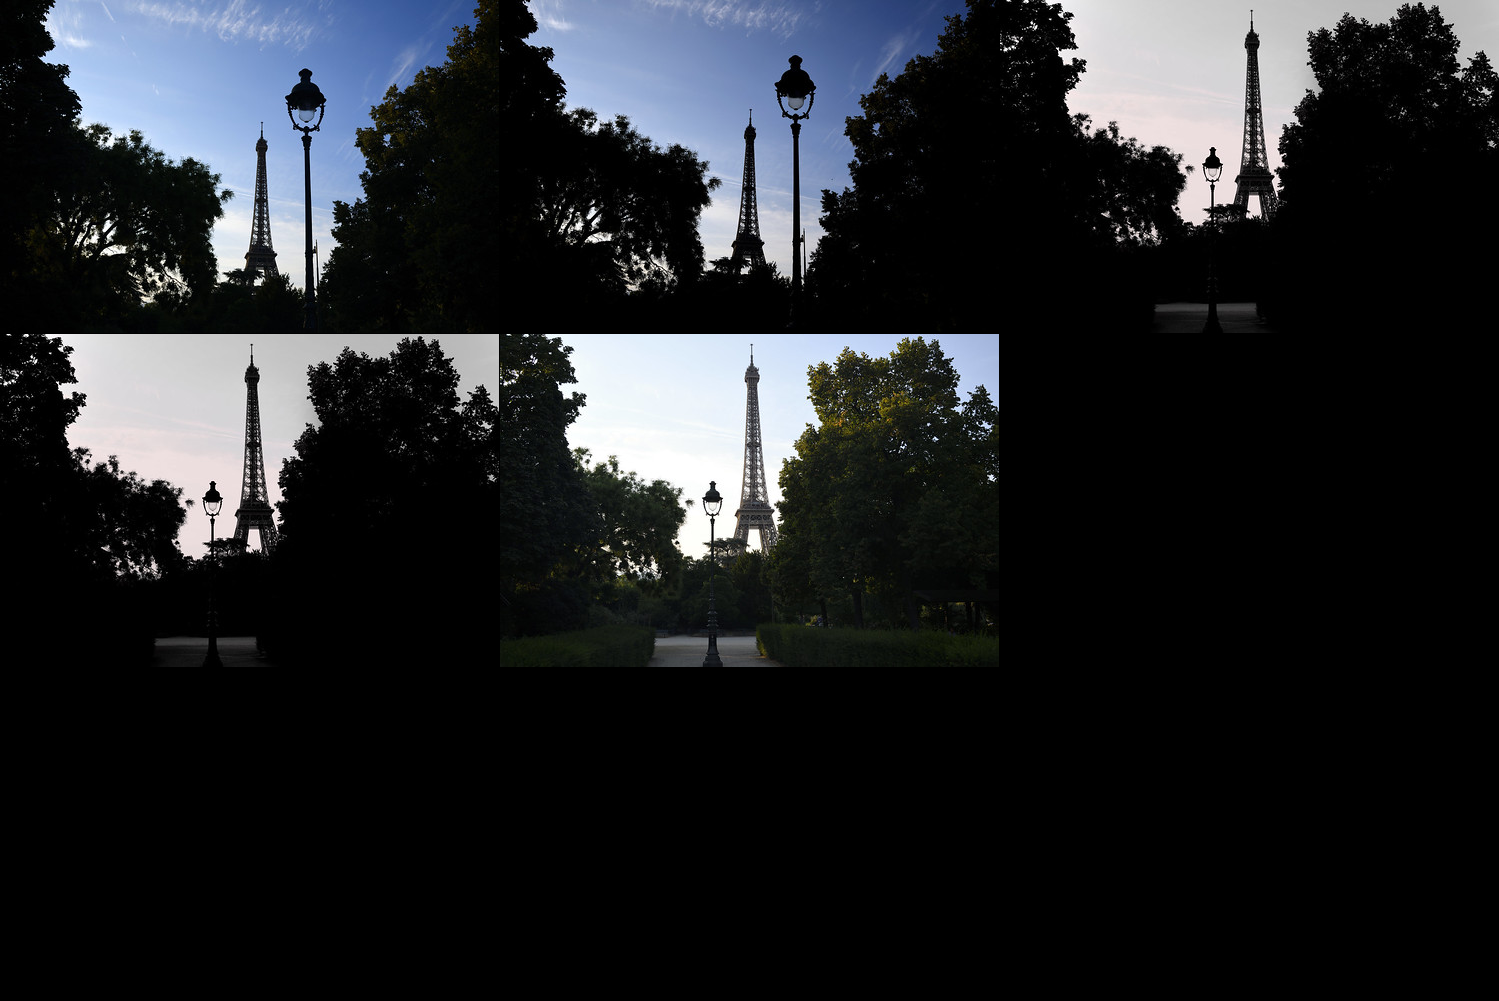

In [7]:
# Visualize photos from the same cluster
cluster_label = 33
grid = visualize_grid(make_tensor(cluster_imgs[cluster_label]))
Image.fromarray(grid.astype("uint8"))

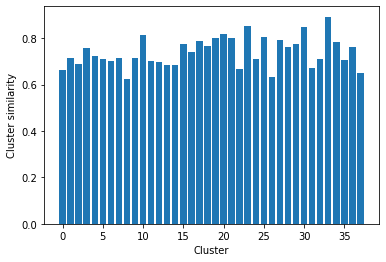

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cluster_sim(X):
    embedding_X = [dataset.get_id(int(photo_id))[2] for photo_id in X[:, 0]]
    embedding_X = np.stack(embedding_X, axis=0)
    return cosine_similarity(embedding_X).mean()

# Quantitative measure of the clusters
cluster_similarities = {}
for label in set(y_train):
    if label == -1: continue
    cluster_X = X[y_train == label]
    cluster_sim = compute_cluster_sim(cluster_X)
    cluster_similarities[label] = cluster_sim

# Plot
fig, ax = plt.subplots()
ax.bar(cluster_similarities.keys(), [cluster_similarities[k] for k in cluster_similarities.keys()])
ax.set_xlabel("Cluster")
ax.set_ylabel("Cluster similarity")
plt.show()

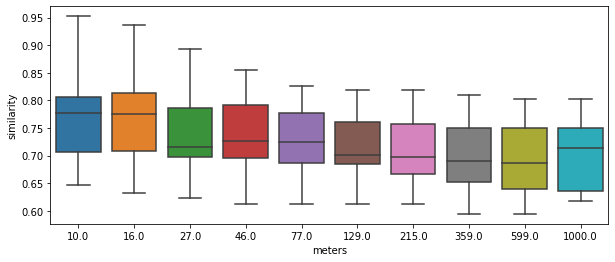

In [9]:
def plot_distance_vs_sim(X):
    df = pd.DataFrame()
    for meters in np.logspace(1, 3, num=10):
        X_train = X[:, 1:]

        # Train clustering using DBSCAN
        kms_per_radian = 6371.0088
        epsilon = (int(meters) * 0.001) / kms_per_radian
        db = DBSCAN(eps=epsilon, algorithm='ball_tree', metric='haversine')
        db.fit(np.radians(X_train))
        y_train = db.labels_

        # Similarities
        for label in set(y_train):
            if label == -1: continue
            cluster_X = X[y_train == label]
            cluster_sim = compute_cluster_sim(cluster_X)
            df = df.append({
                "meters": int(meters),
                "similarity": cluster_sim
            }, ignore_index=True)
        
    return df

exp_meters = plot_distance_vs_sim(X)
fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(x="meters", y="similarity", data=exp_meters, ax=ax)
plt.show()

# Multifeature DBSCAN

In [23]:
from clustering.dbscan import MultiFeatureDBSCAN
from clustering.embedding import WSL, VGG16

params = {
    "dataset": LoadDataset("./data/paris_1000_test.h5"),
    "model": VGG16(-5),
    "weights": (0.33, 0.33, 1-2*0.33),
}
model = MultiFeatureDBSCAN(**params)
model.train(max_data=300, eps=0.2, min_samples=5)

Get data from hdfs5 file...
Images to embeddings...
Vectorization of tags...
Final training set: (300, 2) (300, 150528) (300, 1305)
Compute distance matrix of locations...
Compute distance matrix of embeddings...
Compute distance matrix of tags...
dist_matrix: 0.0 0.5281840654428178+-0.09012336584913945 0.8197516234945676
Training DBSCAN...
Result: 10 clusters
Counts: 6 10.7+-3.6345563690772495 15


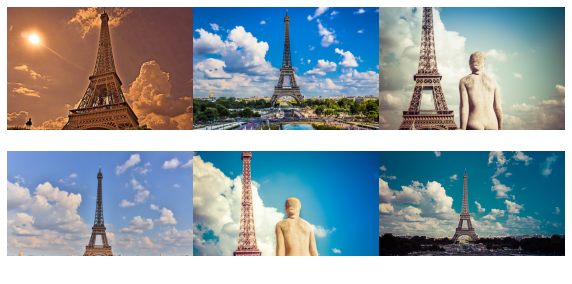

In [24]:
from utils.vis import thumb_grid

# Get images in clusters
cluster_imgs = {}
for label in set(model.labels):
    if label == -1: continue
    photos_id = [model.idx[i] for i in range(model.labels.shape[0]) if model.labels[i] == label]
    cluster_imgs[label] = []
    subset = np.random.choice(len(photos_id), size=min(len(photos_id), 6), replace=False)
    for photo_id in [photos_id[i] for i in subset]:
        _, img, _ = params["dataset"].get_id(int(photo_id))
        cluster_imgs[label].append(img)

# Visualize photos from the same cluster
cluster_label = 1
fig = thumb_grid(cluster_imgs[cluster_label], (3, 3))
fig.set_size_inches(10, 10)
plt.show()

In [26]:
from utils.geojson import GeoJson

# Build GeoJSON
df = pd.DataFrame()
for label in set(model.labels):
    if label == -1: continue
    photos_id = [model.idx[i] for i in range(model.labels.shape[0]) if model.labels[i] == label]
    for photo_id in photos_id:
        metadata, _, _ = params["dataset"].get_id(int(photo_id))
        df = df.append({
            "lat": float(metadata["location"]["latitude"]),
            "lon": float(metadata["location"]["longitude"]),
            "id": metadata["id"],
            "title": str(metadata["title"]) if ("title" in metadata.keys() and metadata["title"] != "") else "(No title)",
            "url": metadata["photo_file_urls"]["Small"],
            "cluster": int(label)
        }, ignore_index=True)

# Export GeoJSON
geojson_data = GeoJson().to_geojson(df, 
    'cluster', # column for grouping to the same pin color
    'lat', # latitude column name
    'lon', # longitude column name
    [c for c in df.columns] # metadata to add in the geojson
)
geojson_data.save_to("geojson-viewer/data.geojson")
df.head()

,cluster,id,lat,lon,title,url
0,0.0,28587621467,48.827567,2.348327,Paris street art,https://live.staticflickr.com/1806/28587621467...
1,0.0,29594500608,48.857251,2.331697,"Paris , France",https://live.staticflickr.com/839/29594500608_...
2,0.0,29604682708,48.827567,2.348327,"H. Lefevre, fabricant de chaussures et de galo...",https://live.staticflickr.com/1824/29604682708...
3,0.0,42569632555,48.827567,2.348327,Paris street art,https://live.staticflickr.com/835/42569632555_...
4,0.0,42757921514,48.827567,2.348327,Paris street art,https://live.staticflickr.com/840/42757921514_...
